<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Load-data" data-toc-modified-id="Load-data-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Load data</a></span></li><li><span><a href="#Data-Growth" data-toc-modified-id="Data-Growth-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Data Growth</a></span></li><li><span><a href="#Hierarchical-Clustering" data-toc-modified-id="Hierarchical-Clustering-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Hierarchical Clustering</a></span></li><li><span><a href="#PCA" data-toc-modified-id="PCA-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>PCA</a></span></li><li><span><a href="#Normalize-to-reference-conditions" data-toc-modified-id="Normalize-to-reference-conditions-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Normalize to reference conditions</a></span></li><li><span><a href="#Expression-variation" data-toc-modified-id="Expression-variation-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Expression variation</a></span></li></ul></div>

<font size="4">This is a template notebook for exploratory analysis on your organism's QC'ed dataset.</font>

In [2]:
import pandas as pd
import os
from os import path
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [3]:
sns.set_style('ticks')

# Load data

In [4]:
org_dir = '../../modulome_paeru/'
os.listdir(org_dir)

['sequence_files',
 '.gitignore',
 'LICENSE',
 '.git',
 'eggNOG',
 'data',
 'README.md']

In [5]:
DF_metadata = pd.read_csv(os.path.join(org_dir,'data','metadata_qc.csv'),index_col=0)
DF_log_tpm = pd.read_csv(os.path.join(org_dir,'data','log_tpm_qc.csv'),index_col=0)

# Data Growth

In [6]:
DF_metadata['ReleaseDate'] = pd.to_datetime(DF_metadata['ReleaseDate'])

In [7]:
first_date = min(DF_metadata['ReleaseDate'])
last_date = max(DF_metadata['ReleaseDate'])
date_range = pd.date_range(start=first_date,end=last_date,freq='YS')

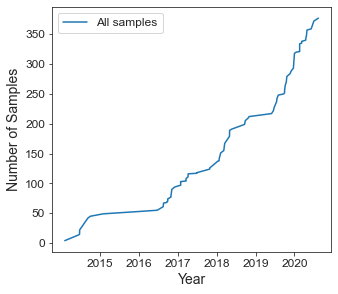

In [8]:
fig,ax = plt.subplots(figsize=(5,5))
growth = DF_metadata['ReleaseDate'].value_counts().sort_index().cumsum()
growth.plot(ax=ax,label='All samples')
plt.xticks(date_range,date_range.strftime('%Y'),rotation=0,ha='center')
ax.tick_params(labelsize=12)
ax.set_xlabel('Year',fontsize=14)
ax.set_ylabel('Number of Samples',fontsize=14)
plt.legend(fontsize=12)

# Hierarchical Clustering

<font size=4> A clustermap is a great way to visualize the global correlations between one sample and all others. The following code uses hierarchical clustering to identify specific clusters in the clustermap <font size=4>
    
<font size=4> To increase the number of clusters, decrease the value of `thresh`. To decrease the number of clusters, increase the value of `thresh` <font size=4>

In [9]:
import scipy.cluster.hierarchy as sch
import matplotlib.patches as patches
# change this to get different number of clusters
thresh = .3

# retrieve clusters using fcluster 
corr = DF_log_tpm.corr()
corr.fillna(0,inplace=True)
dist = sch.distance.pdist(corr)
link = sch.linkage(dist, method='complete')
clst = pd.DataFrame(index=DF_log_tpm.columns)
clst['cluster'] = sch.fcluster(link, thresh * dist.max(), 'distance')

#get colors for each cluster
cm = plt.cm.get_cmap('tab20')
clr = dict(zip(clst.cluster.unique(), cm.colors))
clst['color'] = clst.cluster.map(clr)

print('Number of cluster: ', len(clr))

Number of cluster:  11


<font size="4">To view sample IDs in the clustermap, set `xticklabels` and `yticklabels` to `True`. You can increase the `size` variable to improve readability of sample IDs<font>

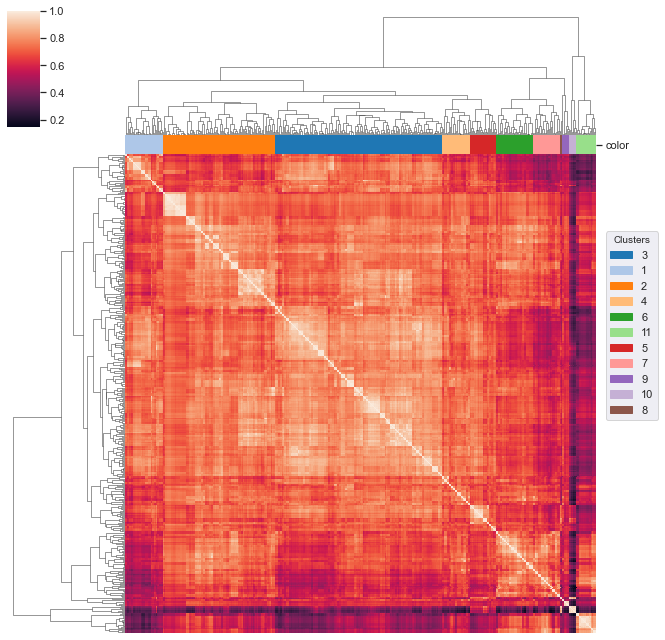

In [10]:
size = 9

legend_TN = [patches.Patch(color=c, label=l) for l,c in clr.items()]

sns.set(rc={'figure.facecolor':'white'})
g = sns.clustermap(DF_log_tpm.corr(), figsize=(size,size), 
                   row_linkage=link, col_linkage=link, col_colors=clst.color,
                  yticklabels=False, xticklabels=False)

l2=g.ax_heatmap.legend(loc='upper left', bbox_to_anchor=(1.01,0.85), handles=legend_TN,frameon=True)
l2.set_title(title='Clusters',prop={'size':10})

# PCA

In [20]:
from sklearn.decomposition import PCA
import numpy as np
sns.set_style('ticks')

<font size="4"> First compute principal components.</font>

In [21]:
pca = PCA()
DF_weights = pd.DataFrame(pca.fit_transform(DF_log_tpm.T),index=DF_log_tpm.columns)
DF_components = pd.DataFrame(pca.components_.T,index=DF_log_tpm.index)

<font size="4"> Next, plot the cumulative explained variance</font>

Number of dimensions for 99% of variance: 238


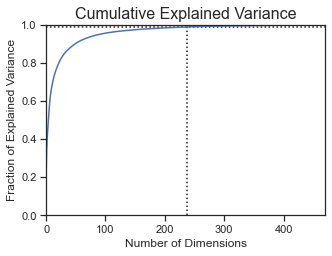

In [22]:
# Set the explained variance threshold
var_cutoff = 0.99

fig,ax = plt.subplots(figsize=(5,3.5))
pca_var = np.cumsum(pca.explained_variance_ratio_)
ax.plot(pca_var)
dims = np.where(pca_var > var_cutoff)[0][0] + 1
ax.vlines(dims,0,1,linestyles='dotted')
ax.hlines(var_cutoff,0,len(DF_log_tpm.columns),linestyles='dotted')
ax.set_ylim(0,1)
ax.set_xlim(0,len(DF_log_tpm.columns))
ax.set_ylabel('Fraction of Explained Variance',fontsize=12)
ax.set_xlabel('Number of Dimensions',fontsize=12)
ax.set_title('Cumulative Explained Variance',fontsize=16)
print('Number of dimensions for 99% of variance:',dims)

<font size="4">Finally, plot the first two principle components. The following code colors data by Project Name.</font>

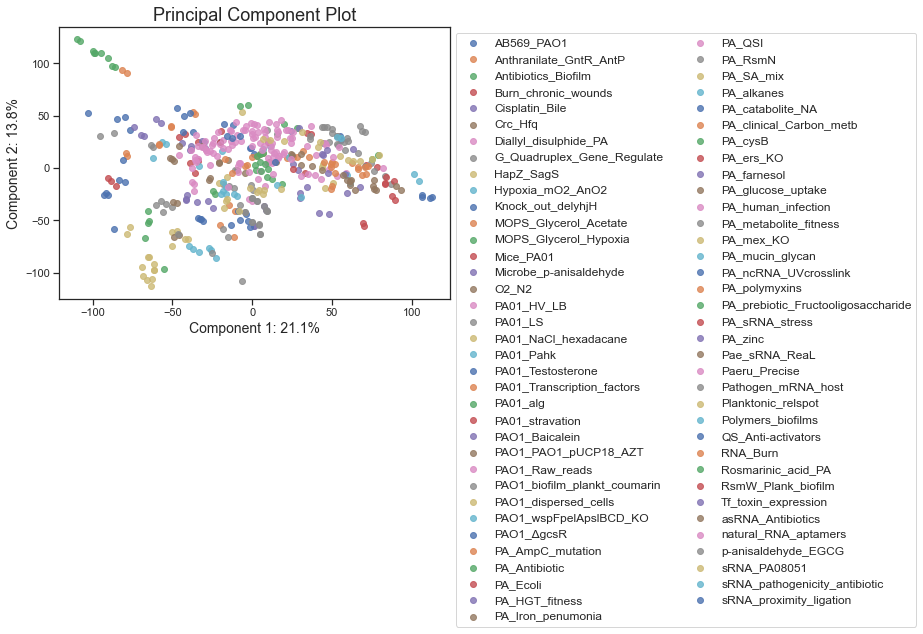

In [23]:
fig,ax = plt.subplots(figsize=(7,5))
for name,group in DF_metadata.groupby('project_name'):
    idx = DF_log_tpm.loc[:,group.index.tolist()].columns.tolist()
    ax.scatter(DF_weights.loc[idx,0],
               DF_weights.loc[idx,1],
               label=name,alpha=0.8)
ax.set_xlabel('Component 1: %.1f%%'%(pca.explained_variance_ratio_[0]*100),fontsize=14)
ax.set_ylabel('Component 2: %.1f%%'%(pca.explained_variance_ratio_[1]*100),fontsize=14)
ax.set_title('Principal Component Plot',fontsize=18)
plt.legend(bbox_to_anchor=(1,1),fontsize=12,ncol=2)

# Normalize to reference conditions

In [24]:
project_exprs = []
for name,group in DF_metadata.groupby('project_name'):
    ref_cond = group.reference_condition.unique()
    
    # Ensure that there is only one reference condition per project
    assert(len(ref_cond) == 1)
    ref_cond = ref_cond[0]
    
    # Ensure the reference condition is in fact in the project
    assert(ref_cond in group.condition_name.tolist())
    
    # Get reference condition sample ids
    ref_samples = group[group.condition_name == ref_cond].index
    
    # Get reference condition expression
    ref_expr = DF_log_tpm[ref_samples].mean(axis=1)
    
    # Subtract reference expression from project
    project_exprs.append(DF_log_tpm[group.index].sub(ref_expr,axis=0))

DF_log_tpm_norm = pd.concat(project_exprs,axis=1)

In [25]:
DF_log_tpm_norm.head()

,SRX7442752,SRX7442753,SRX7442754,SRX7442755,SRX7442756,SRX7442757,SRX7442758,SRX7442759,SRX7442761,SRX7874204,...,SRX6874331,SRX6874332,SRX6874333,SRX6874334,SRX2962081,SRX2962082,SRX2255950,SRX2255951,SRX2255954,SRX2255955
Geneid,,,,,,,,,,,,,,,,,,,,,
PA0001,-0.059838,0.059838,-0.223628,-0.064501,0.272055,0.250233,0.132425,-0.012312,0.207182,-0.039016,...,-0.044699,-0.299603,0.086665,0.169547,-0.024739,0.024739,-0.037832,0.157251,0.046101,-0.046101
PA0002,-0.129988,0.129988,-0.775982,-0.558346,0.113325,0.225710,-0.015325,-0.625404,-0.506919,-0.022261,...,-0.059230,-0.119672,0.107077,0.338205,0.006953,-0.006953,0.218948,0.240875,-0.054297,0.054297
PA0003,-0.059231,0.059231,-0.029049,0.134841,-0.247534,-0.236541,-0.262634,0.157336,0.162652,-0.027968,...,-0.093783,-0.302721,-0.337056,-0.365332,-0.016488,0.016488,-0.046473,0.186933,0.015561,-0.015561
PA0004,-0.106282,0.106282,-0.020711,0.004618,-0.158098,-0.123305,-0.211630,-0.005664,0.179065,-0.010633,...,-0.176887,-0.227301,-0.192066,-0.396876,-0.043922,0.043922,0.359508,0.465754,-0.004769,0.004769
PA0005,0.130988,-0.130988,-0.090968,-0.174002,-0.172446,0.083005,-0.118166,-0.095737,-0.040259,0.012668,...,-0.212691,-0.520186,-0.086707,-0.064131,0.064923,-0.064923,0.392341,0.213062,0.034251,-0.034251


<font size=4>Uncomment this code to save the log_tpm_norm file</font>

In [26]:
# DF_log_tpm_norm.to_csv(path.join(org_dir,'log_tpm_norm.csv'))

# Expression variation

(array([4.810e+02, 1.594e+03, 1.512e+03, 8.230e+02, 5.370e+02, 2.840e+02,
        1.540e+02, 7.400e+01, 5.300e+01, 2.900e+01, 2.200e+01, 6.000e+00,
        1.000e+00, 1.000e+00, 1.000e+00]),
 array([0.28984736, 0.46153045, 0.63321354, 0.80489663, 0.97657972,
        1.14826281, 1.3199459 , 1.49162898, 1.66331207, 1.83499516,
        2.00667825, 2.17836134, 2.35004443, 2.52172752, 2.69341061,
        2.86509369]),
 <a list of 15 Patch objects>)

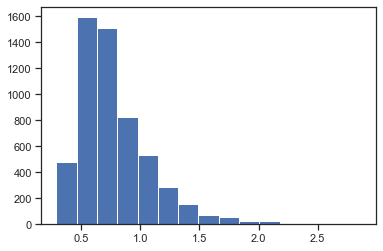

In [30]:
plt.hist(DF_log_tpm_norm.std(axis=1),bins=15)

Text(0, 0.5, 'Standard Deviation')

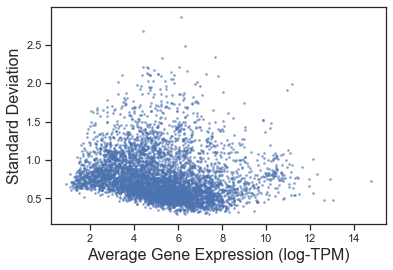

In [29]:
# Plot of average expression against standard deviation of expression (normalized within each project)
plt.scatter(DF_log_tpm.mean(axis=1),DF_log_tpm_norm.std(axis=1),s=3,alpha=0.5)
plt.xlabel('Average Gene Expression (log-TPM)',fontsize=16)
plt.ylabel('Standard Deviation',fontsize=16)